In [15]:
#Install the modules needed for this analysis 

# import pip
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install matplotlib
# !pip install shap
# !pip install statsmodels.sm

In [16]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
#from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
 
from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import sklearn.metrics

import statsmodels.api as sm

### Loading data


In [17]:
dat_read = pd.read_csv('imputed_dat14_re_JMF.csv')
#print(dat_read)
df = pd.DataFrame(dat_read)
print(df.shape)


(5114, 68)


In [18]:
#predictor set
X = df.iloc[:,0:67]
X.shape

(5114, 67)

In [19]:
#outcome
y = df['EducationAttainment']
print(y)

0       12.0
1       10.0
2       10.0
3       14.0
4       14.0
        ... 
5109    16.0
5110    16.0
5111    12.0
5112    14.0
5113    12.0
Name: EducationAttainment, Length: 5114, dtype: float64


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=666)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4091, 67)
(1023, 67)
(4091,)
(1023,)


In [22]:
print(X_train.index)
print(X_test.index)

Index([4230, 4423,   98,  175, 4188,  743, 3894, 2626, 2964, 2082,
       ...
        563,  222, 1115, 1469, 2462, 1993,   70, 2878, 1950, 1922],
      dtype='int64', length=4091)
Index([3800, 3239, 4544, 3291, 1502, 4275,  209, 2986, 4980, 2971,
       ...
       1596, 1594, 3791, 4815, 4241, 3770,  656, 3454, 4673, 1439],
      dtype='int64', length=1023)


In [23]:
weights_read = pd.read_csv('Wave4Weights_c.csv')
df_weights = pd.DataFrame(weights_read)
print(df_weights)
weights = df_weights['GSWGT4_2']
weights_train = weights[X_train.index]
weights_test = weights[X_test.index]

           AID      GSWGT4_2
0     57101310   2936.707073
1     57103869   9388.942184
2     57109625   7918.203020
3     57111071   3850.820387
4     57113943   8559.854200
...        ...           ...
5109  99719930   2048.697141
5110  99719939   2666.193398
5111  99719970  10256.701951
5112  99719976  12675.529312
5113  99719978  15049.667047

[5114 rows x 2 columns]


## Benchmark: OLS regression

In [24]:
ols = LinearRegression()
ols.fit(X_train, y_train, sample_weight = weights_train)
pred_test_ols= ols.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test,pred_test_ols)) 
print(sklearn.metrics.r2_score(y_test, pred_test_ols))

3.2394589342357407
0.3742131546426022


## Lasso

### Inner-loop cross-validation: tuning regularization parameter

In [25]:
alphas_full = np.concatenate((np.linspace(0.000001, 0.000009, 9),np.linspace(0.00001, 0.00009, 9),
                            np.linspace(0.0001, 0.0009, 9), np.linspace(0.001, 0.009, 9), 
                             np.linspace(0.01, 0.09, 9), np.linspace(0.1, 0.9, 9),
                             np.linspace(1, 9, 9), np.linspace(10, 90, 9), np.linspace(100, 900, 9),
                            np.linspace(1000, 9000, 9), np.linspace(10000, 90000, 9),
                              np.linspace(100000, 900000, 10)),axis=None)
alphas_full

array([1.00000000e-06, 2.00000000e-06, 3.00000000e-06, 4.00000000e-06,
       5.00000000e-06, 6.00000000e-06, 7.00000000e-06, 8.00000000e-06,
       9.00000000e-06, 1.00000000e-05, 2.00000000e-05, 3.00000000e-05,
       4.00000000e-05, 5.00000000e-05, 6.00000000e-05, 7.00000000e-05,
       8.00000000e-05, 9.00000000e-05, 1.00000000e-04, 2.00000000e-04,
       3.00000000e-04, 4.00000000e-04, 5.00000000e-04, 6.00000000e-04,
       7.00000000e-04, 8.00000000e-04, 9.00000000e-04, 1.00000000e-03,
       2.00000000e-03, 3.00000000e-03, 4.00000000e-03, 5.00000000e-03,
       6.00000000e-03, 7.00000000e-03, 8.00000000e-03, 9.00000000e-03,
       1.00000000e-02, 2.00000000e-02, 3.00000000e-02, 4.00000000e-02,
       5.00000000e-02, 6.00000000e-02, 7.00000000e-02, 8.00000000e-02,
       9.00000000e-02, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
       4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
       8.00000000e-01, 9.00000000e-01, 1.00000000e+00, 2.00000000e+00,
      

In [26]:
model_lasso = Lasso(random_state=666)
distributions = dict(alpha=alphas_full)
clf_lasso = RandomizedSearchCV(model_lasso, distributions, n_iter=100,verbose=2,
                               scoring=('neg_mean_squared_error', 'r2'),refit= 'neg_mean_squared_error', 
                               cv=5, random_state=666)
search = clf_lasso.fit(X_train, y_train, sample_weight = weights_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ........................................alpha=9e-06; total time=   0.0s
[CV] END ........................................alpha=9e-06; total time=   0.0s
[CV] END ........................................alpha=9e-06; total time=   0.0s
[CV] END ........................................alpha=9e-06; total time=   0.0s
[CV] END ........................................alpha=9e-06; total time=   0.0s
[CV] END ......................................alpha=60000.0; total time=   0.0s
[CV] END ......................................alpha=60000.0; total time=   0.0s
[CV] END ......................................alpha=60000.0; total time=   0.0s
[CV] END ......................................alpha=60000.0; total time=   0.0s
[CV] END ......................................alpha=60000.0; total time=   0.0s
[CV] END ........................................alpha=4e-06; total time=   0.0s
[CV] END .....................................

In [27]:
search.best_estimator_

Lasso(alpha=np.float64(0.009), random_state=666)

In [28]:
search.best_score_

np.float64(-3.3755790570823434)

### Outer loop training-test

In [29]:
lasso_final = Lasso(alpha=0.009, random_state=666)
lasso_final.fit(X_train, y_train, sample_weight = weights_train)
pred_test_lasso= lasso_final.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test,pred_test_lasso)) 
print(sklearn.metrics.r2_score(y_test, pred_test_lasso))

3.2113382713431395
0.37964540159438265


## Decision trees

### Inner-loop cross-validation: tuning regularization parameter

In [30]:
max_depth_full=list(range(5,21))
print(max_depth_full)
min_samples_split_full = list(range(2,41))
print(min_samples_split_full)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [31]:
model_dt = DecisionTreeRegressor(random_state=666)
distributions = dict(max_depth=max_depth_full, min_samples_split = min_samples_split_full)
clf_dt = RandomizedSearchCV(model_dt, distributions, n_iter=100,verbose=2,
                               scoring=('neg_mean_squared_error'),refit= 'neg_mean_squared_error', 
                               cv=5, random_state=666)
search = clf_dt.fit(X_train, y_train, sample_weight = weights_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=7, min_sa

In [32]:
search.best_estimator_

DecisionTreeRegressor(max_depth=5, min_samples_split=35, random_state=666)

In [33]:
search.best_score_

np.float64(-3.9684694834726395)

### Outer loop training-test

In [34]:
dt_final = DecisionTreeRegressor(max_depth=5, min_samples_split=35, random_state=666)
dt_final.fit(X_train, y_train, sample_weight = weights_train)
pred_test_dt= dt_final.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test,pred_test_dt)) 
print(sklearn.metrics.r2_score(y_test, pred_test_dt))

3.700979438504669
0.2850583092510075


## Random Forest

### Inner-loop cross-validation: tuning regularization parameter

In [35]:
n_estimators_full=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
print(n_estimators_full)
max_depth_full=list(range(5,21))
print(max_depth_full)
min_samples_split_full = list(range(2,41)) #integer 1 for min samples split caused error
print(min_samples_split_full)

[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [36]:
# model_rf = RandomForestRegressor(random_state=666)
# distributions = dict(n_estimators= n_estimators_full, 
#                      max_depth=max_depth_full, min_samples_split = min_samples_split_full)
# clf_rf = RandomizedSearchCV(model_rf, distributions, n_iter=100,verbose=2,n_jobs=4,
#                                scoring=('neg_mean_squared_error'),refit= 'neg_mean_squared_error', 
#                                cv=5, random_state=666)
# search = clf_rf.fit(X_train, y_train, sample_weight = weights_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=14, min_samples_split=14, n_estimators=10; total time=   0.2s
[CV] END max_depth=14, min_samples_split=14, n_estimators=10; total time=   0.2s
[CV] END max_depth=14, min_samples_split=14, n_estimators=10; total time=   0.1s
[CV] END max_depth=14, min_samples_split=14, n_estimators=10; total time=   0.1s
[CV] END max_depth=14, min_samples_split=14, n_estimators=10; total time=   0.2s
[CV] END max_depth=13, min_samples_split=32, n_estimators=200; total time=   2.4s
[CV] END max_depth=13, min_samples_split=32, n_estimators=200; total time=   2.4s
[CV] END max_depth=13, min_samples_split=32, n_estimators=200; total time=   2.4s
[CV] END max_depth=13, min_samples_split=32, n_estimators=200; total time=   2.4s
[CV] END max_depth=13, min_samples_split=32, n_estimators=200; total time=   2.4s
[CV] END max_depth=10, min_samples_split=8, n_estimators=500; total time=   6.6s
[CV] END max_depth=10, min_samples_split=

In [ ]:
import joblib

# Save the fitted search object
# joblib.dump(search, 'rf_random_search.pkl')

# Load it later
search = joblib.load('rf_random_search.pkl')



In [37]:
search.best_estimator_

RandomForestRegressor(max_depth=18, min_samples_split=12, n_estimators=1000,
                      random_state=666)

In [38]:
search.best_score_

np.float64(-3.4244007955560356)

### Outer loop training-test

In [39]:
rf_final = RandomForestRegressor(max_depth=18, min_samples_split=12, n_estimators=1000,
                      random_state=666)
rf_final.fit(X_train, y_train, sample_weight = weights_train)
pred_test_rf= rf_final.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test,pred_test_rf)) 
print(sklearn.metrics.r2_score(y_test, pred_test_rf))

3.185207114332585
0.3846933230661921


## XGBoost

### Inner-loop cross-validation: tuning regularization parameter

In [40]:
learning_rate_full = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
print(learning_rate_full)
n_estimators_full=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
print(n_estimators_full)
max_depth_full=list(range(5,21))
print(max_depth_full)

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [41]:
# model_xgb = GradientBoostingRegressor(random_state=666)
# distributions = dict(n_estimators= n_estimators_full, 
#                      max_depth=max_depth_full, learning_rate = learning_rate_full)
# clf_xgb = RandomizedSearchCV(model_xgb, distributions, n_iter=100,verbose=2,n_jobs=4,
#                                scoring=('neg_mean_squared_error'),refit= 'neg_mean_squared_error', 
#                                cv=5, random_state=666)
# search = clf_xgb.fit(X_train, y_train, sample_weight = weights_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ....learning_rate=1, max_depth=18, n_estimators=600; total time=   0.3s
[CV] END ....learning_rate=1, max_depth=18, n_estimators=600; total time=   0.4s
[CV] END ....learning_rate=1, max_depth=18, n_estimators=600; total time=   0.4s
[CV] END ....learning_rate=1, max_depth=18, n_estimators=600; total time=   0.5s
[CV] END ....learning_rate=1, max_depth=18, n_estimators=600; total time=   0.4s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=600; total time=  20.8s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=600; total time=  21.0s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=600; total time=  21.2s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=600; total time=  21.1s
[CV] END learning_rate=0.005, max_depth=15, n_estimators=500; total time=  18.0s
[CV] END learning_rate=0.005, max_depth=15, n_estimators=500; total time=  18.1s
[CV] END learning_rate=0.005, max_depth=15, n_

In [ ]:
import joblib

# Save the fitted search object
# joblib.dump(search, 'xgb_random_search.pkl')

# Load it later
search = joblib.load('xgb_random_search.pkl')


In [42]:
search.best_estimator_

GradientBoostingRegressor(learning_rate=0.005, max_depth=7, n_estimators=1000,
                          random_state=666)

In [43]:
search.cv_results_ #200, 5, leaarning_rate = 0.1

{'mean_fit_time': array([ 0.40146937, 21.37400446, 18.25277247,  2.26064701,  0.7107728 ,
         7.71170731,  2.48967218,  1.31534748,  2.05897284,  1.75804377,
         9.84761906,  1.70279713,  8.7593514 ,  7.9579495 ,  0.51699929,
        12.39607415, 11.54900765,  1.29487672,  2.99159985,  8.4643364 ,
        25.71477132,  6.5422173 , 33.22184453,  7.77688446, 10.44619226,
        10.96172714, 20.29543662,  2.02666082, 16.35667019, 32.20621524,
         2.0807044 ,  7.79436522,  1.44247956,  5.1059896 ,  7.77968273,
        17.38657098,  3.81805944,  9.8425962 ,  1.12705536, 17.09353008,
         4.30846357, 38.30894399,  0.42117262,  0.82275238,  4.29956784,
        14.54467549,  3.5102284 ,  3.26529875,  8.93339181,  0.42307172,
         7.78118949, 21.40385237, 20.86388483,  7.68255987, 23.96426668,
         4.80843744,  6.34136863, 17.65321531, 17.70526223,  8.60229926,
        14.13134398,  0.1732717 , 30.80323501,  6.69746294, 17.92189903,
         9.05306726,  2.30382366, 

In [44]:
search.best_score_

np.float64(-3.457905499129737)

### Outer loop training-test

In [45]:
xgb_final = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=200,
                      random_state=666)
xgb_final.fit(X_train, y_train, sample_weight = weights_train)
pred_test_xgb= xgb_final.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test,pred_test_xgb)) 
print(sklearn.metrics.r2_score(y_test, pred_test_xgb))

3.3730479334500956
0.3484069196848728


### RF is the best model

## SHAP interpretations

In [46]:
#!echo y | conda install shap

import shap

In [47]:
shap_values = shap.TreeExplainer(rf_final).shap_values(X_train)

Exception ignored in: <function ResourceTracker.__del__ at 0x106997ce0>
Traceback (most recent call last):
  File "/Users/anuk/miniconda3/envs/AddHealth/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/anuk/miniconda3/envs/AddHealth/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/anuk/miniconda3/envs/AddHealth/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107ddfce0>
Traceback (most recent call last):
  File "/Users/anuk/miniconda3/envs/AddHealth/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/anuk/miniconda3/envs/AddHealth/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/anuk/miniconda3/envs/AddHealth/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessErr

In [48]:
shap_values

array([[ 1.91557940e-04, -2.47012564e-04,  1.04313693e-02, ...,
         5.44877138e-03,  4.45912703e-03,  7.60817734e-04],
       [ 1.73226639e-04,  4.55410283e-04,  1.31461251e-02, ...,
         1.63174509e-03,  3.07353498e-03,  3.00424362e-03],
       [ 4.69701073e-04,  4.77548053e-05, -2.40812953e-02, ...,
         1.21243386e-02,  1.11925885e-03,  8.58339993e-03],
       ...,
       [ 4.13684794e-05,  2.17602300e-03, -2.79947389e-02, ...,
         6.91288275e-03,  2.14113875e-03,  2.49888926e-03],
       [ 3.21170966e-04,  4.11094051e-05,  1.28485787e-02, ...,
         3.21487837e-03,  3.40947416e-03,  8.70216778e-03],
       [ 2.61563256e-04, -1.97149835e-04,  1.14452818e-02, ...,
         5.90424974e-03,  2.86949098e-03,  9.87726266e-05]],
      shape=(4091, 67))

In [ ]:
shap_values = joblib.load('shap_values.pkl')

In [ ]:
# explainer_c = shap.TreeExplainer(rf_final, X_train)
# shap_values_c = explainer_c(X_train) #get the correct format of shap values for the scatter plot

# Save
joblib.dump(shap_values_c, 'shap_values_c.pkl')

# Later load
shap_values_c = joblib.load('shap_values_c.pkl')


In [ ]:
# shap_interaction_values = shap.TreeExplainer(rf_final).shap_interaction_values(X_train)

In [79]:
import joblib

# Save
joblib.dump(shap_interaction_values, 'shap_interaction_values.pkl')

# Later load
shap_interaction_values = joblib.load('shap_interaction_values.pkl')


In [54]:
!pip install matplotlib
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=70)

ImportError: matplotlib is not installed so plotting is not available! Run `pip install matplotlib` to fix this.

### recursive feature elimination

In [55]:
#weighted 5-fold cross-validation
def cross_val_scores_weighted(model, X_train, y_train, weights, cv=5, 
                              metrics=[sklearn.metrics.mean_squared_error, sklearn.metrics.r2_score]):
    X_train_re = X_train.reset_index(drop=True)
    y_train_re = y_train.reset_index(drop=True)
    weights_train_re = weights_train.reset_index(drop=True)
    kf = KFold(n_splits=cv, random_state = 666, shuffle= True)
    kf.get_n_splits(X_train, y_train)
    scores = [[] for metric in metrics]
    j=1
    for tune_index, eval_index in kf.split(X_train, y_train):
        print(j)
        model_clone = sklearn.base.clone(model)
        X_tune, X_eval = X_train_re.iloc[tune_index,:], X_train_re.iloc[eval_index,:]
        y_tune, y_eval = y_train_re[tune_index], y_train_re[eval_index]
        weights_tune, weights_eval = weights_train_re[tune_index], weights_train_re[eval_index]
        #print(weights[train_index], weights[test_index])
        model_clone.fit(X_tune,y_tune,sample_weight=weights_tune)
        y_pred = model_clone.predict(X_eval)
        for i, metric in enumerate(metrics):
            score = metric(y_eval, y_pred, sample_weight = weights_eval)
            scores[i].append(score)
        j=j+1
    return scores

In [56]:
shap_values.shape

(4091, 67)

In [57]:
shap_absmean=np.mean(np.abs(shap_values),0)

In [58]:
shap_absmean

array([5.73773219e-04, 2.66989737e-04, 2.52861996e-02, 2.70646513e-03,
       5.38417198e-03, 3.11537816e-02, 7.08460261e-03, 2.77775014e-02,
       5.18009447e-02, 3.04012263e-01, 4.21612209e-01, 6.80871877e-02,
       2.21434490e-02, 1.13565417e-02, 1.27967429e-03, 3.43111319e-01,
       8.02411566e-03, 8.26208525e-02, 2.69034473e-03, 1.91360575e-02,
       2.67312283e-02, 7.31020957e-02, 1.73619717e-02, 1.91593257e-02,
       1.86322185e-02, 7.79358069e-02, 2.02615256e-02, 1.65276623e-02,
       5.19937415e-02, 1.09879847e-02, 7.57823021e-03, 1.34342146e-02,
       1.17788442e-02, 7.72129289e-02, 1.10721488e-01, 4.72807590e-02,
       6.49649090e-03, 8.87459730e-03, 2.91904376e-02, 9.59490259e-02,
       1.90729800e-03, 2.46868604e-02, 1.73527275e-02, 2.82409391e-03,
       1.84168258e-03, 6.62996461e-03, 2.82035650e-03, 2.33934201e-03,
       1.77140935e-03, 2.05323296e-01, 1.30160143e-03, 1.57718347e-02,
       2.22591601e-02, 5.88718254e-03, 1.98221176e-03, 1.99413950e-03,
      

In [59]:
feature_names = X_train.columns.values.tolist()
feature_names

['ResidentMotherPresence',
 'ResidentFatherPresence',
 'ResidentBiologicalParents',
 'ParentMarried',
 'ParentPartnered',
 'HouseholdSize',
 'NumberSiblings',
 'BirthOrder',
 'ParentAge',
 'MotherEducation',
 'FatherEducation',
 'MotherOccupationPrestige',
 'FatherOccupationPrestige',
 'MotherWorkForPay',
 'FatherWorkForPay',
 'FamilyIncome',
 'PublicAssistance',
 'Welfare',
 'EconomicHardship',
 'FamilySocialSupport',
 'SharedDinner',
 'IntergenerationalClosure',
 'ParentConnectionFriends',
 'MotherRelationshipQuality',
 'FatherRelationshipQuality',
 'MotherSharedActivity',
 'FatherSharedActivity',
 'ParentPartnerRelationship',
 'ParentControl',
 'MotherSupervision',
 'FatherSupervision',
 'MotherInvolveSchool',
 'FatherInvolveSchool',
 'ParentPTA',
 'MotherEducationExpectation',
 'FatherEducationExpectation',
 'MotherNativity',
 'FatherNativity',
 'ParentYearsInUS',
 'ParentReligiosity',
 'EnglishHome',
 'ParentHealth',
 'ParentSmoke',
 'MotherAlcoholic',
 'FatherAlcoholic',
 'Mother

In [ ]:
# X_rfe = X_train
# feature_names = X_train.columns.values.tolist()
# mses = []
# r2s=[]
# feature_eliminate = []
# imps_all=shap_absmean.tolist()
# while len(feature_names)>0:
#     scores = cross_val_scores_weighted(rf_final, X_rfe, y_train, weights_train)
#     mse_avg=np.mean(scores[0])
#     r2_avg=np.mean(scores[1])
#     print('mse', mse_avg)
#     mses.append(mse_avg)
#     print('r2', r2_avg)
#     r2s.append(r2_avg)
#     least_imp_ind = np.argmin(imps_all)
#     print(feature_names[least_imp_ind], least_imp_ind)
#     X_rfe = X_rfe.drop(feature_names[least_imp_ind], axis=1)
#     feature_eliminate.append(feature_names[least_imp_ind])
#     feature_names.pop(least_imp_ind)
#     imps_all.pop(least_imp_ind)
#     print(X_rfe.shape)

1
2
3
4
5
mse 3.43279438873198
r2 0.32525724230999753
ResidentFatherPresence 1
(4091, 66)
1
2
3
4
5
mse 3.43184367663173
r2 0.3254407220610317
ResidentMotherPresence 0
(4091, 65)
1
2
3
4
5
mse 3.432755538643589
r2 0.32528901008250155
OtherRace 60
(4091, 64)
1
2
3
4
5
mse 3.4301012452490127
r2 0.32580550297499783
FatherWorkForPay 12
(4091, 63)
1
2
3
4
5
mse 3.430052230940486
r2 0.3258154519787003
DrugHousehold 47
(4091, 62)
1
2
3
4
5
mse 3.431997833141623
r2 0.325445700980851
FatherDisable 45
(4091, 61)
1
2
3
4
5
mse 3.4317947893060476
r2 0.3254778879764152
FatherAlcoholic 41
(4091, 60)
1
2
3
4
5
mse 3.428892080278898
r2 0.32604663944944845
EnglishHome 37
(4091, 59)
1
2
3
4
5
mse 3.4302971939023847
r2 0.325767694095621
YearsLiveStepfather 47
(4091, 58)
1
2
3
4
5
mse 3.4280083711111273
r2 0.32622660936174297
BornToAdolescentParent 47
(4091, 57)
1
2
3
4
5
mse 3.4278773116261334
r2 0.32624613597546936
MotherDisable 42
(4091, 56)
1
2
3
4
5
mse 3.429092639395777
r2 0.3260007958356931
Economi

In [89]:
# import joblib
# import pandas as pd

# # Save everything to disk
# joblib.dump({
#     'mses': mses,
#     'r2s': r2s,
#     'feature_eliminate': feature_eliminate,
#     'remaining_features': X_rfe.columns.tolist(),
#     'X_rfe': X_rfe,
# }, 'rfe_results_rf.pkl')

rfe_data = joblib.load('rfe_results_rf.pkl')
mses = rfe_data['mses']
r2s = rfe_data['r2s']
feature_eliminate = rfe_data['feature_eliminate']
X_rfe = rfe_data['X_rfe']


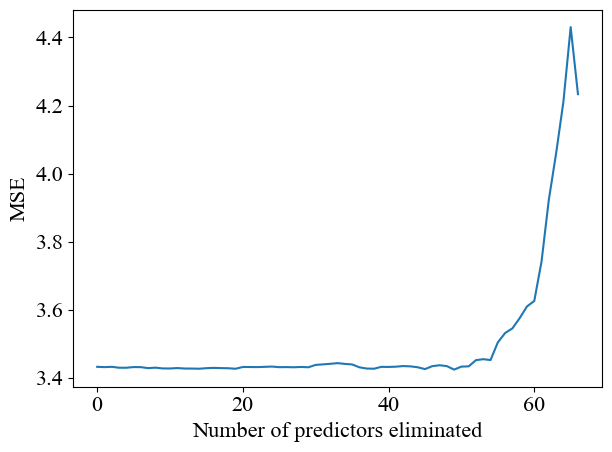

In [90]:
#plot the RFE curve
eli = range(67)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.plot(eli, mses)
plt.ylabel('MSE')
plt.xlabel('Number of predictors eliminated')
plt.tight_layout()
plt.savefig('mse_rfe', dpi=1000)
plt.show()

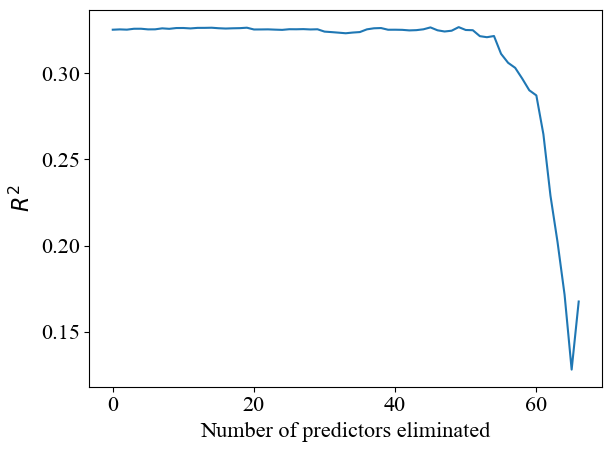

In [62]:
eli = range(67)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.plot(eli, r2s)
plt.ylabel('$R^{2}$')
plt.xlabel('Number of predictors eliminated')
plt.tight_layout()
plt.savefig('r2_rfe', dpi=1000)
plt.show()

In [63]:
mses

[np.float64(3.43279438873198),
 np.float64(3.43184367663173),
 np.float64(3.432755538643589),
 np.float64(3.4301012452490127),
 np.float64(3.430052230940486),
 np.float64(3.431997833141623),
 np.float64(3.4317947893060476),
 np.float64(3.428892080278898),
 np.float64(3.4302971939023847),
 np.float64(3.4280083711111273),
 np.float64(3.4278773116261334),
 np.float64(3.429092639395777),
 np.float64(3.4277431761394803),
 np.float64(3.4276388407806193),
 np.float64(3.4271741708869294),
 np.float64(3.428748959404335),
 np.float64(3.4296365929352737),
 np.float64(3.4289702979119996),
 np.float64(3.4285435611825053),
 np.float64(3.4271150937059716),
 np.float64(3.4323244786428),
 np.float64(3.432156671999292),
 np.float64(3.4319817006458457),
 np.float64(3.432698609938329),
 np.float64(3.433492403148926),
 np.float64(3.4317005425069764),
 np.float64(3.4319662870248715),
 np.float64(3.4314445299671137),
 np.float64(3.4323393328900638),
 np.float64(3.4314578926853563),
 np.float64(3.438405556611

In [65]:
mses.index(3.4222179171778633) #53; this is the last low MSE


ValueError: 3.4222179171778633 is not in list

In [66]:
r2s

[np.float64(0.32525724230999753),
 np.float64(0.3254407220610317),
 np.float64(0.32528901008250155),
 np.float64(0.32580550297499783),
 np.float64(0.3258154519787003),
 np.float64(0.325445700980851),
 np.float64(0.3254778879764152),
 np.float64(0.32604663944944845),
 np.float64(0.325767694095621),
 np.float64(0.32622660936174297),
 np.float64(0.32624613597546936),
 np.float64(0.3260007958356931),
 np.float64(0.3263140456228978),
 np.float64(0.32632361877181537),
 np.float64(0.326405637068161),
 np.float64(0.326111405186605),
 np.float64(0.32593721083634736),
 np.float64(0.3260758963868998),
 np.float64(0.3261612376031892),
 np.float64(0.32641743216494234),
 np.float64(0.32538421011660656),
 np.float64(0.3254097573119633),
 np.float64(0.3254585968679106),
 np.float64(0.3252950007799117),
 np.float64(0.32516174062730574),
 np.float64(0.32553812193999054),
 np.float64(0.3255085053124326),
 np.float64(0.32559668033492184),
 np.float64(0.32540348980634914),
 np.float64(0.32550690646740416),

In [67]:
r2s[53]

np.float64(0.3209034645728046)

In [68]:
feature_eliminate[:52] #this is all the features eliminated up till the last low MSE

['ResidentFatherPresence',
 'ResidentMotherPresence',
 'OtherRace',
 'FatherWorkForPay',
 'DrugHousehold',
 'FatherDisable',
 'FatherAlcoholic',
 'EnglishHome',
 'YearsLiveStepfather',
 'BornToAdolescentParent',
 'MotherDisable',
 'EconomicHardship',
 'ParentMarried',
 'FatherObese',
 'MotherAlcoholic',
 'Latinx',
 'NativeAmerican',
 'BioMotherIncarceration',
 'Black',
 'AAPI',
 'ParentPartnered',
 'NonresidentBioFatherDeceased',
 'MotherNativity',
 'MotherObese',
 'NumberSiblings',
 'FatherSupervision',
 'PhysicalAbuse',
 'PublicAssistance',
 'BioFatherIncarceration',
 'FatherNativity',
 'MotherSupervision',
 'MotherWorkForPay',
 'FatherInvolveSchool',
 'MotherInvolveSchool',
 'FamilyAccessMedicalCare',
 'ParentPartnerRelationship',
 'ParentSmoke',
 'ParentConnectionFriends',
 'FatherRelationshipQuality',
 'FamilySocialSupport',
 'MotherRelationshipQuality',
 'FatherSharedActivity',
 'FatherOccupationPrestige',
 'ParentPreviousRelationship',
 'ParentHealth',
 'ResidentBiologicalParent

In [69]:
feature_eliminate[53:] #these are the key predictors

['ParentAge',
 'ParentControl',
 'MotherOccupationPrestige',
 'IntergenerationalClosure',
 'ParentPTA',
 'MotherSharedActivity',
 'Welfare',
 'ParentReligiosity',
 'MotherEducationExpectation',
 'Sex',
 'SmokerHousehold',
 'MotherEducation',
 'FamilyIncome',
 'FatherEducation']

In [70]:
len(feature_eliminate[53:] )

14

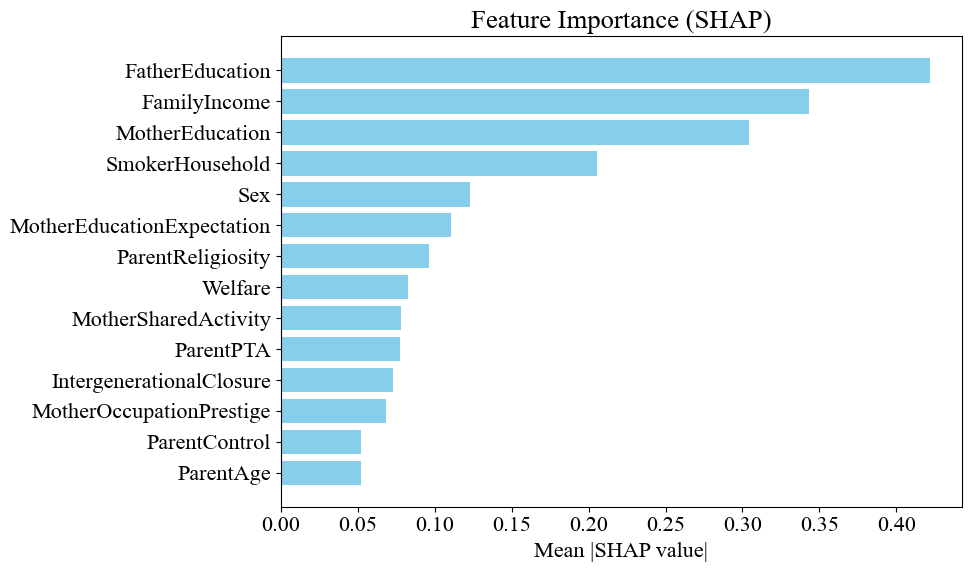

In [74]:
# shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=14)

# Compute mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Get the top 14 features
max_display = 14
top_indices = np.argsort(mean_abs_shap)[-max_display:][::-1]
top_features = X_train.columns[top_indices]
top_values = mean_abs_shap[top_indices]

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_values, color='skyblue')
plt.xlabel("Mean |SHAP value|")
plt.title("Feature Importance (SHAP)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


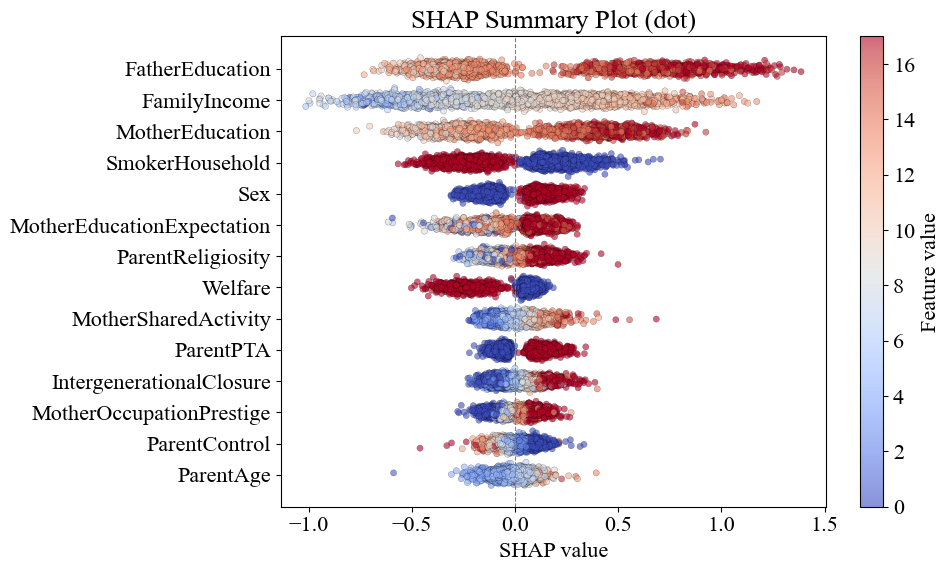

In [77]:
# shap.summary_plot(shap_values, X_train, max_display=14)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to DataFrame for convenience
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
X_df = pd.DataFrame(X_train, columns=X_train.columns)

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_df).mean().sort_values(ascending=False)

# Select top features
max_display = 14
top_features = mean_abs_shap.iloc[:max_display].index

# Plot
plt.figure(figsize=(10, 6))

for i, feature in enumerate(reversed(top_features)):
    shap_vals = shap_df[feature]
    feat_vals = X_df[feature]
    
    # Jittered strip plot
    plt.scatter(
        shap_vals,
        [i + np.random.normal(0, 0.1, size=shap_vals.shape[0])] if shap_vals.ndim > 1 else i + np.random.normal(0, 0.1, size=len(shap_vals)),
        c=feat_vals,
        cmap='coolwarm',
        alpha=0.6,
        edgecolor='k',
        linewidth=0.2,
        s=20
    )

plt.yticks(ticks=range(len(top_features)), labels=list(reversed(top_features)))
plt.xlabel("SHAP value")
plt.title("SHAP Summary Plot (dot)")
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
plt.colorbar(label="Feature value")
plt.tight_layout()
plt.show()


Red on the right: positive relation; red on the left: negative relation

In [ ]:
#define a function for SHAP scatter plot with regression line
def scatter_regression(feature):
    y_sv=shap_values_c[:,feature].values
    lowess = sm.nonparametric.lowess(y_sv, X_train[feature], frac=.3)
    _,ax = plt.subplots()
    ax.plot(*list(zip(*lowess)), color="black", )
    shap.plots.scatter(shap_values_c[:,feature], ax=ax)

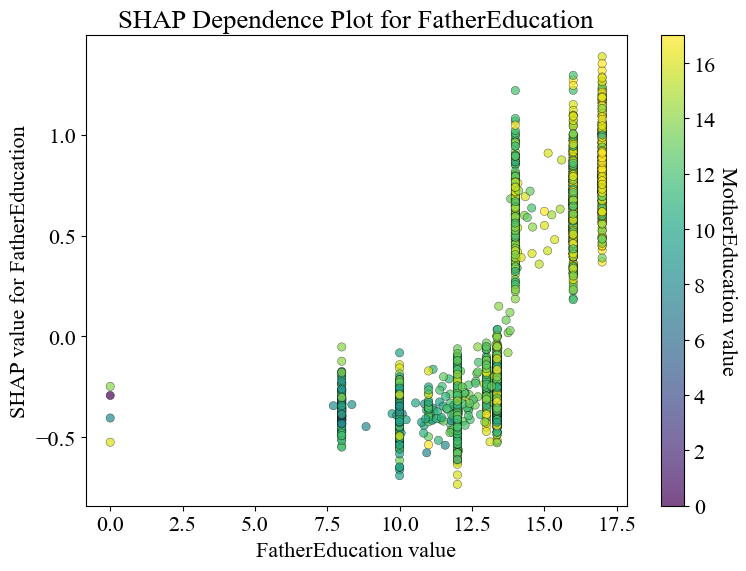

In [78]:
# shap.dependence_plot("FatherEducation", shap_values, X_train)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure data is in DataFrame format
X_df = pd.DataFrame(X_train)
shap_df = pd.DataFrame(shap_values, columns=X_df.columns)

feature = "FatherEducation"
x = X_df[feature]
y = shap_df[feature]

# Optional: find most correlated feature for color
correlated_feature = X_df.corrwith(X_df[feature]).drop(feature).abs().idxmax()
color = X_df[correlated_feature]

# Scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=color, cmap='viridis', alpha=0.7, edgecolor='k', linewidth=0.3)
plt.xlabel(f"{feature} value")
plt.ylabel(f"SHAP value for {feature}")
plt.title(f"SHAP Dependence Plot for {feature}")
cbar = plt.colorbar(scatter)
cbar.set_label(f"{correlated_feature} value", rotation=270, labelpad=15)
plt.tight_layout()
plt.show()



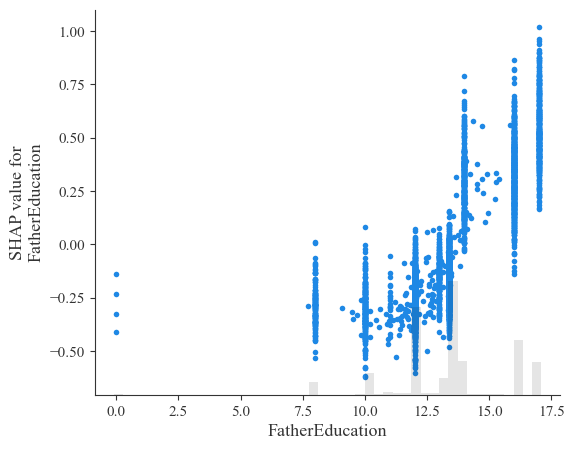

In [ ]:
shap.plots.scatter(shap_values_c[:,"FatherEducation"])

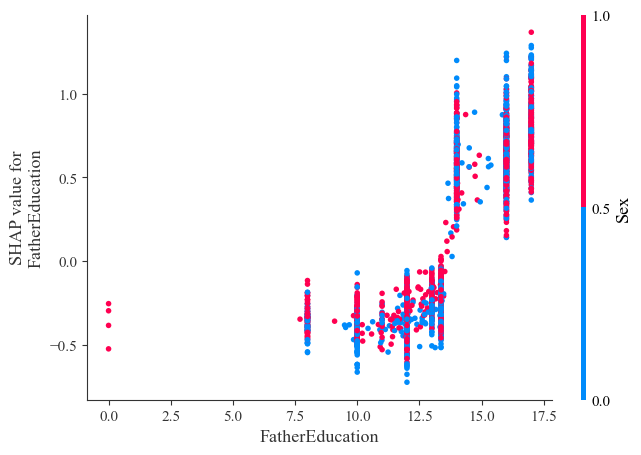

In [ ]:
shap.dependence_plot("FatherEducation", shap_values, X_train, interaction_index='Sex')

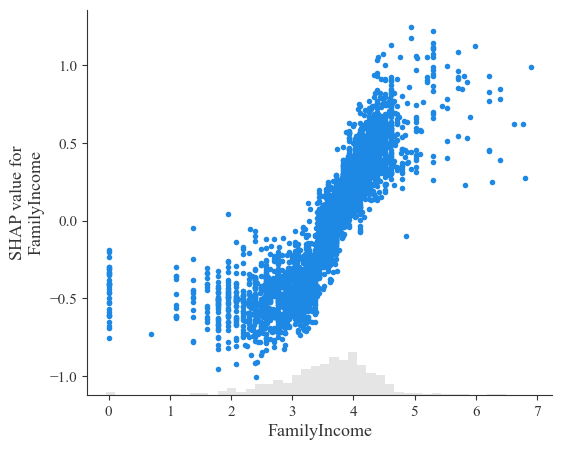

In [ ]:
shap.plots.scatter(shap_values_c[:,"FamilyIncome"])

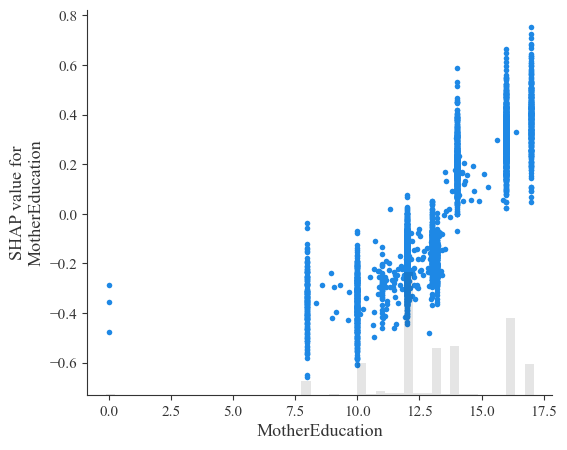

In [ ]:
shap.plots.scatter(shap_values_c[:,"MotherEducation"])

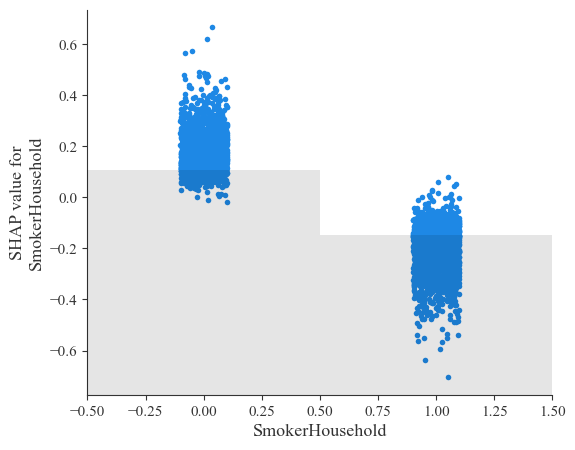

In [ ]:
shap.plots.scatter(shap_values_c[:,"SmokerHousehold"])

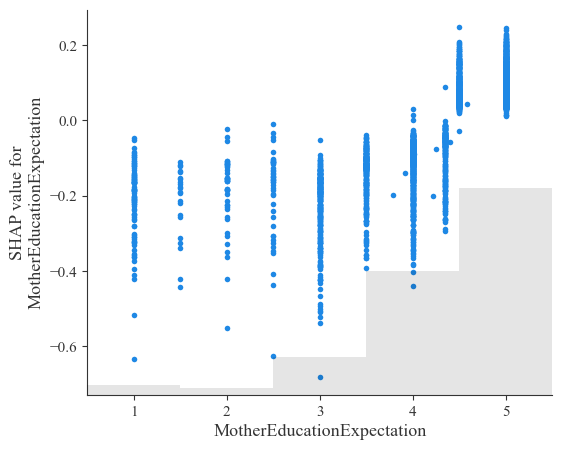

In [ ]:
shap.plots.scatter(shap_values_c[:,"MotherEducationExpectation"])

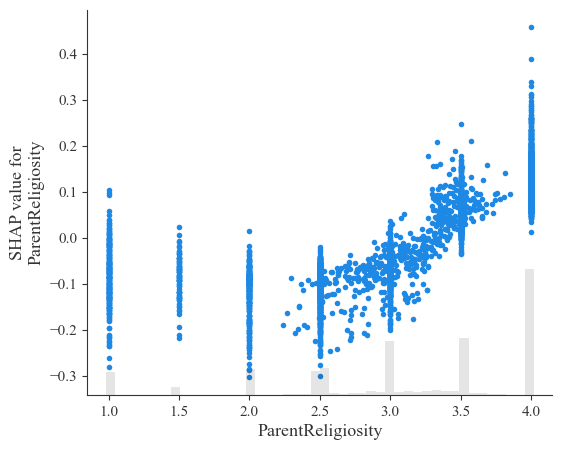

In [ ]:
shap.plots.scatter(shap_values_c[:,"ParentReligiosity"])

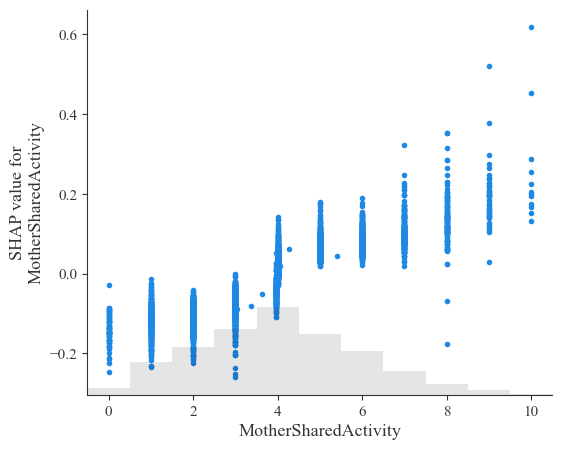

In [ ]:
shap.plots.scatter(shap_values_c[:,"MotherSharedActivity"])

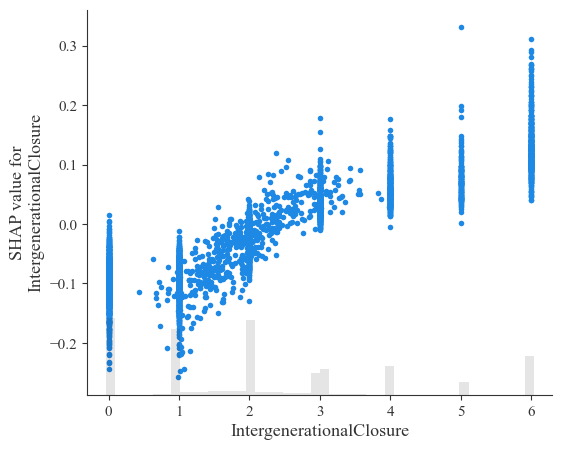

In [ ]:
shap.plots.scatter(shap_values_c[:,"IntergenerationalClosure"])

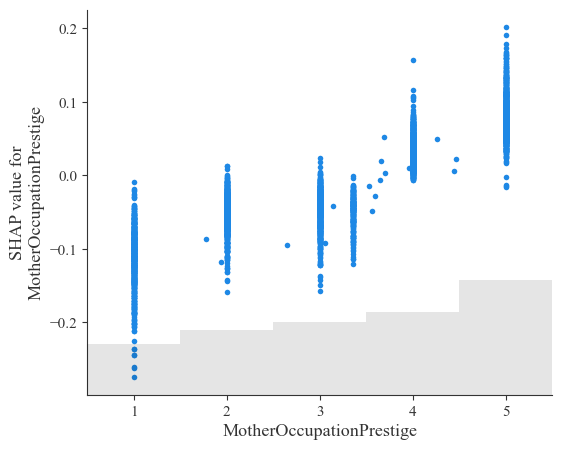

In [ ]:
shap.plots.scatter(shap_values_c[:,"MotherOccupationPrestige"])

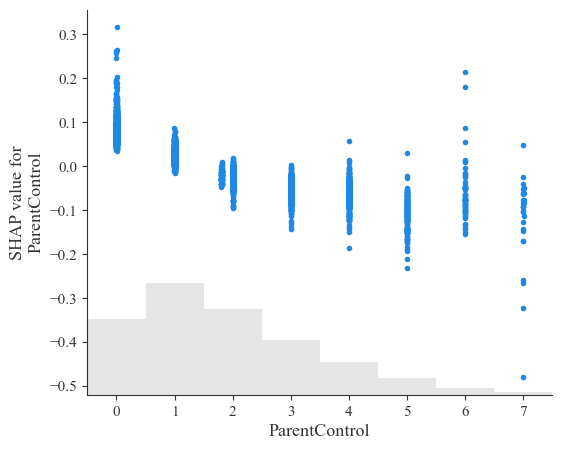

In [ ]:
shap.plots.scatter(shap_values_c[:,"ParentControl"])

### Make force plots

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[0], shap_values_c.values[0], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[0], shap_values_c.values[0], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot1.png')

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[1], shap_values_c.values[1], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[1], shap_values_c.values[1], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot2.png')

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[50], shap_values_c.values[50], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[50], shap_values_c.values[50], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot3.png')

In [ ]:
X_train.iloc[50]['IntergenerationalClosure']

0.0

In [ ]:
y_train.iloc[50]

14.0

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[100], shap_values_c.values[100], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[100], shap_values_c.values[100], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot4.png')

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[150], shap_values_c.values[150], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[150], shap_values_c.values[150], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot5.png')

In [ ]:
X_train.iloc[150]['EmotionalAbuse']

5.0

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[250], shap_values_c.values[250], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[250], shap_values_c.values[250], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot6.png')

In [ ]:
X_train.iloc[250]['Age']

13.0

In [ ]:
X_train.iloc[250]['MotherOccupationPrestige']

2.0

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[300], shap_values_c.values[300], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[300], shap_values_c.values[300], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot7.png')

In [ ]:
X_train.shape

(4091, 67)

### Interaction plots

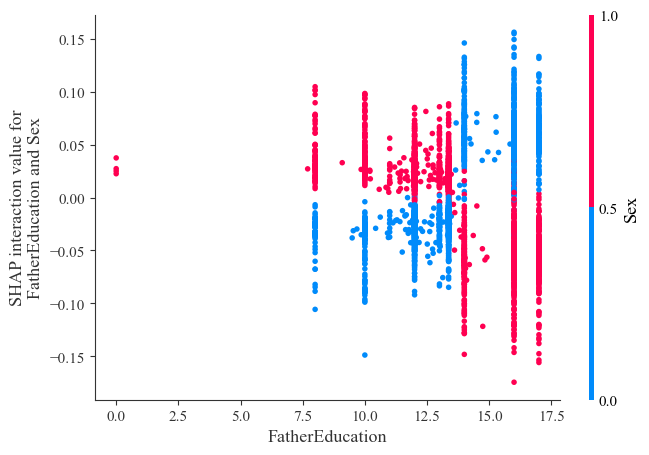

In [ ]:
shap.dependence_plot(
    ("FatherEducation", "Sex"),
    shap_interaction_values, X_train,
    display_features=X_train)

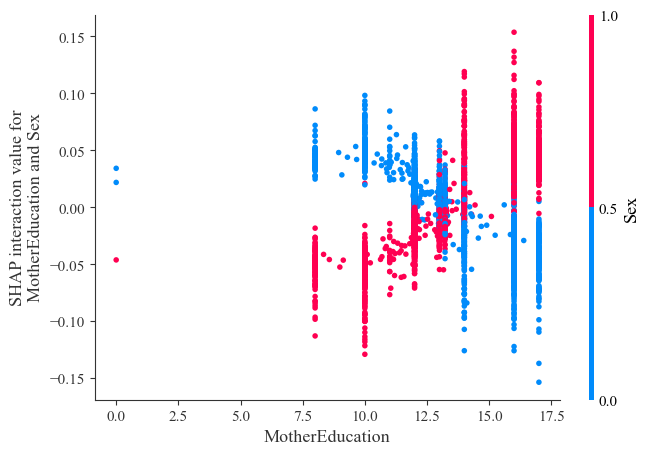

In [ ]:
shap.dependence_plot(
    ("MotherEducation", "Sex"),
    shap_interaction_values, X_train,
    display_features=X_train)

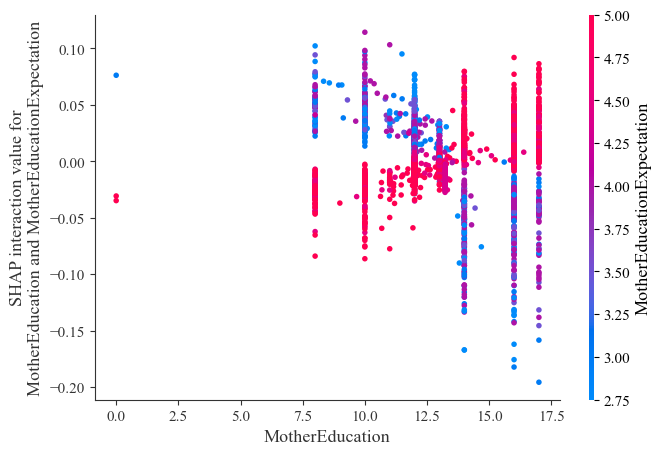

In [ ]:
shap.dependence_plot(
    ("MotherEducation", "MotherEducationExpectation"),
    shap_interaction_values, X_train,
    display_features=X_train)

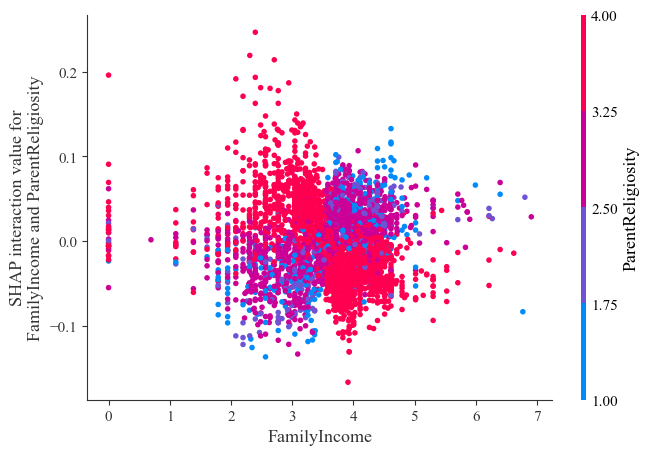

In [ ]:
shap.dependence_plot(
    ("FamilyIncome", "ParentReligiosity"),
    shap_interaction_values, X_train,
    display_features=X_train)

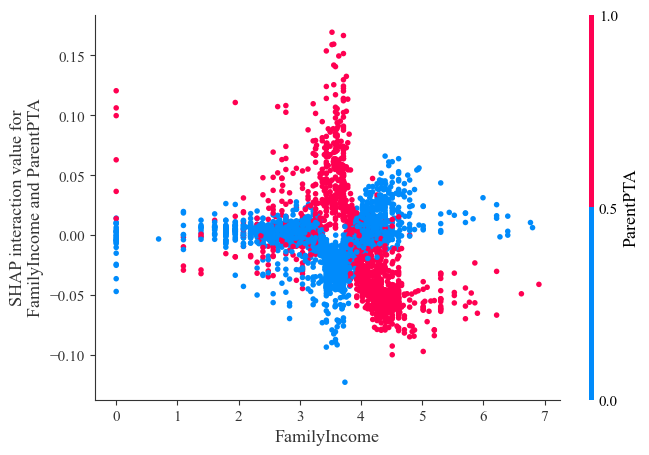

In [ ]:
shap.dependence_plot(
    ("FamilyIncome", "ParentPTA"),
    shap_interaction_values, X_train,
    display_features=X_train)

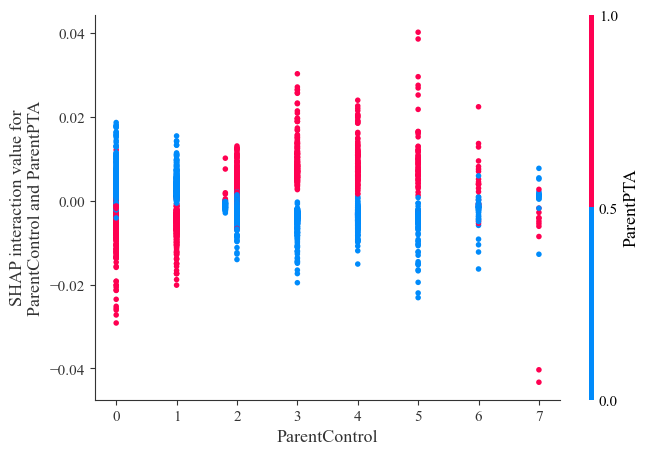

In [ ]:
shap.dependence_plot(
    ("ParentControl", "ParentPTA"),
    shap_interaction_values, X_train,
    display_features=X_train)

In [ ]:
shap.dependence_plot(
    ("FamilyIncome", "ParentReligiosity"),
    shap_interaction_values, X_train,
    display_features=X_train)

In [ ]:
import pandas as pd
import numpy as np
import os
import wget
import math

from pathlib import Path
from matplotlib import pyplot as plt
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
np.random.seed(0)